In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

# Nama file zip yang ingin diekstrak
zip_file_path = "/content/drive/MyDrive/dataset/cotton.zip"

# Direktori tempat Anda ingin mengekstrak file
extract_to_directory = "/content"

# Membuka file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Mengekstrak seluruh isi file ke direktori tertentu
    zip_ref.extractall(extract_to_directory)

print("File zip berhasil diekstrak.")

File zip berhasil diekstrak.


In [3]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
# Re-sizing all the Images
IMAGE_SIZE = [224, 224]

In [5]:
train_path = '/content/cotton_2/train'
valid_path = '/content/cotton_2/val'

In [6]:
# Here we will be using imagenet weights
vgg16 = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [7]:
# don't train existing weights
for layer in vgg16.layers:
    layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('/content/cotton_2/train/*')
folders = [folder.split('/')[-1] for folder in folders]  # Extract class names

In [9]:
# Flatten the input
x = Flatten()(vgg16.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
prediction = Dense(len(folders), activation='softmax')(x)

In [10]:
# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [11]:
# Model Summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
# Compile Model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
# Use the Image Data Generator to import the images from the dataset
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Make sure you provide the same target size as initialized for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

Found 1348 images belonging to 4 classes.


In [16]:
# Plot augmented images
def plot_augmented_images(image_generator, num_images):
    # Get a batch of images and labels
    images, labels = next(image_generator)

    # Ensure num_images does not exceed the number of images in the batch
    num_images = min(num_images, len(images))

    # Get class labels from the generator
    class_labels = list(image_generator.class_indices.keys())

    # Plot the images
    plt.figure(figsize=(15, 9))  # Adjusted figure size for better layout
    for i in range(num_images):
        plt.subplot(3, 5, i + 1)  # 3 rows, 5 columns
        plt.imshow(images[i])
        plt.title(f'Label: {class_labels[np.argmax(labels[i])]}')
        plt.axis('off')

    # Adjust layout to reduce space between rows and columns
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

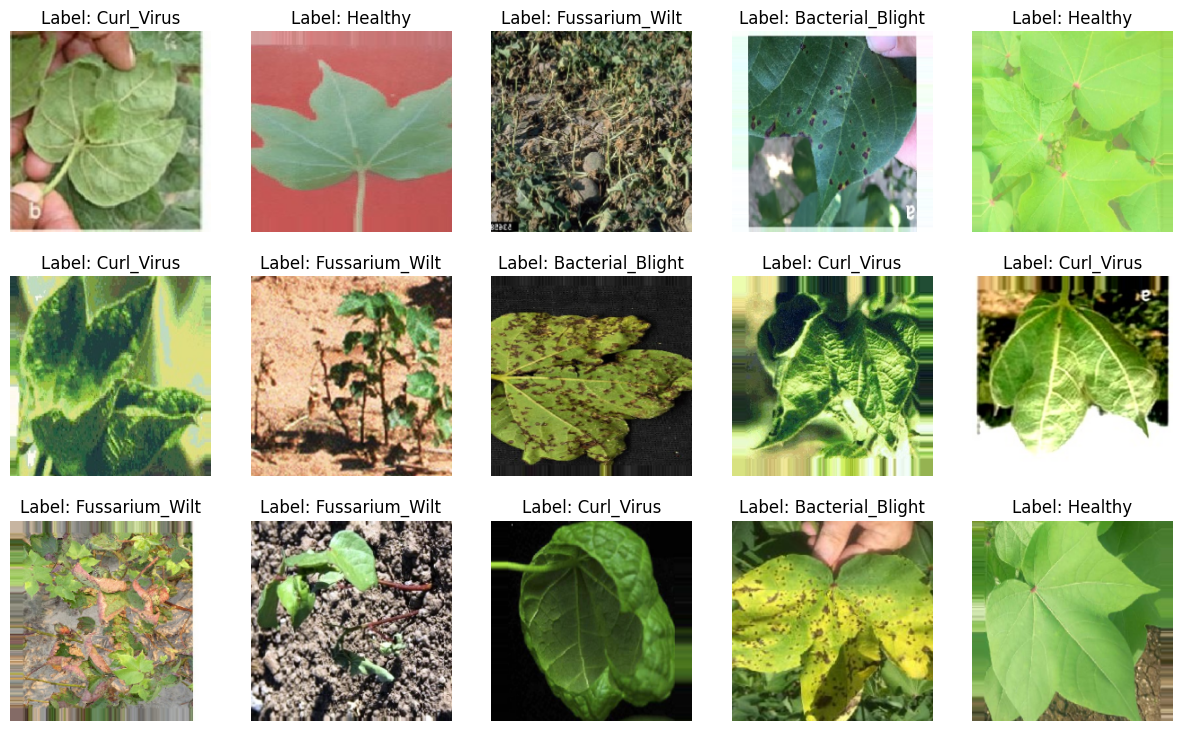

In [17]:
# Plot 15 augmented images
plot_augmented_images(training_set, 15)

In [18]:
# Fit the model
history = model.fit(training_set,
                    epochs=10,
                    steps_per_epoch=len(training_set))

Epoch 1/10
43/43 [==============================] - 35s 485ms/step - loss: 0.7745 - accuracy: 0.7300
Epoch 2/10
43/43 [==============================] - 21s 478ms/step - loss: 0.3402 - accuracy: 0.8746
Epoch 3/10
43/43 [==============================] - 20s 473ms/step - loss: 0.2726 - accuracy: 0.9028
Epoch 4/10
43/43 [==============================] - 22s 500ms/step - loss: 0.1847 - accuracy: 0.9429
Epoch 5/10
43/43 [==============================] - 20s 460ms/step - loss: 0.1303 - accuracy: 0.9555
Epoch 6/10
43/43 [==============================] - 22s 502ms/step - loss: 0.1268 - accuracy: 0.9599
Epoch 7/10
43/43 [==============================] - 21s 489ms/step - loss: 0.1233 - accuracy: 0.9599
Epoch 8/10
43/43 [==============================] - 21s 495ms/step - loss: 0.0980 - accuracy: 0.9696
Epoch 9/10
43/43 [==============================] - 20s 465ms/step - loss: 0.0798 - accuracy: 0.9822
Epoch 10/10
43/43 [==============================] - 21s 499ms/step - loss: 0.1031 - accura

In [19]:
# Function to get the predictions and true labels
def get_predictions_and_labels(generator):
    predictions = []
    labels = []
    for i in range(len(generator)):
        X, y = generator[i]
        preds = model.predict(X)
        predictions.extend(np.argmax(preds, axis=1))
        labels.extend(np.argmax(y, axis=1))
    return np.array(predictions), np.array(labels)

In [20]:
# Get predictions and true labels for training data
train_preds, train_labels = get_predictions_and_labels(training_set)

1/1 [==============================] - 0s 188ms/step


In [21]:
# Confusion Matrix and Classification Report for training data
train_cm = confusion_matrix(train_labels, train_preds)
train_cr = classification_report(train_labels, train_preds, target_names=folders)

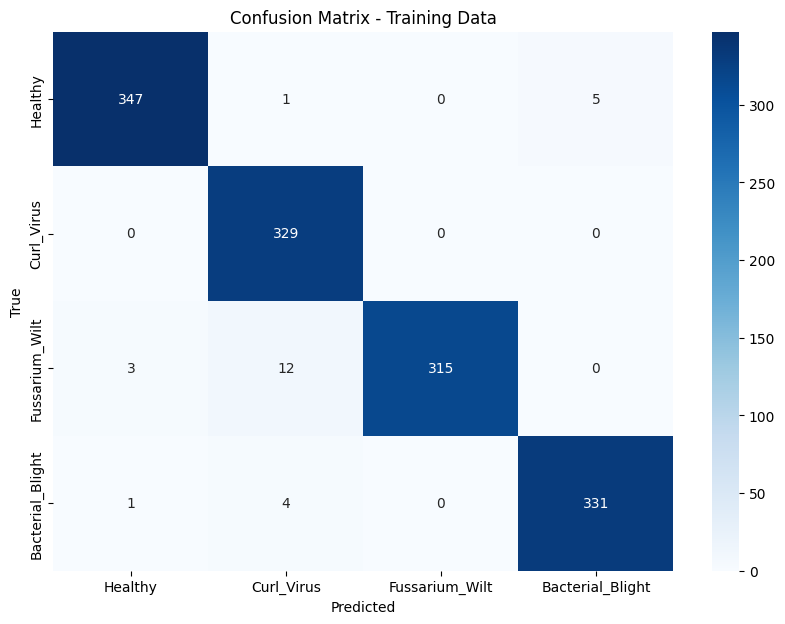

In [22]:
# Plot confusion matrix for training data
plt.figure(figsize=(10, 7))
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.title('Confusion Matrix - Training Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
print("Classification Report - Training Data")
print(train_cr)

Classification Report - Training Data
                  precision    recall  f1-score   support

         Healthy       0.99      0.98      0.99       353
      Curl_Virus       0.95      1.00      0.97       329
  Fussarium_Wilt       1.00      0.95      0.98       330
Bacterial_Blight       0.99      0.99      0.99       336

        accuracy                           0.98      1348
       macro avg       0.98      0.98      0.98      1348
    weighted avg       0.98      0.98      0.98      1348



In [24]:
# Prepare the validation data
validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 344 images belonging to 4 classes.


In [25]:
validation_steps = len(validation_generator)
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_steps, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

11/11 [==============================] - 7s 693ms/step


In [26]:
# Confusion Matrix and Classification Report for validation data
val_cm = confusion_matrix(true_classes, predicted_classes)
val_cr = classification_report(true_classes, predicted_classes, target_names=folders)

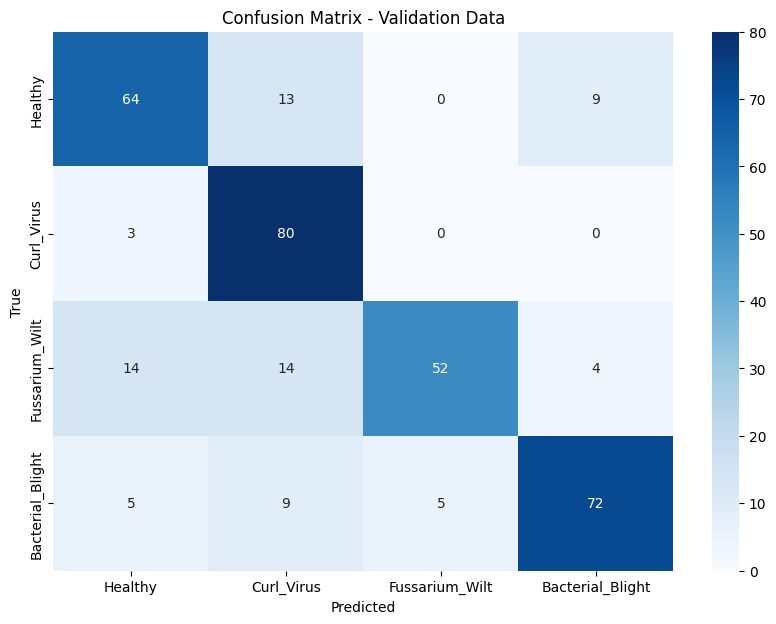

In [27]:
# Plot confusion matrix for validation data
plt.figure(figsize=(10, 7))
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', xticklabels=folders, yticklabels=folders)
plt.title('Confusion Matrix - Validation Data')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [28]:
print("Classification Report - Validation Data")
print(val_cr)

Classification Report - Validation Data
                  precision    recall  f1-score   support

         Healthy       0.74      0.74      0.74        86
      Curl_Virus       0.69      0.96      0.80        83
  Fussarium_Wilt       0.91      0.62      0.74        84
Bacterial_Blight       0.85      0.79      0.82        91

        accuracy                           0.78       344
       macro avg       0.80      0.78      0.78       344
    weighted avg       0.80      0.78      0.78       344



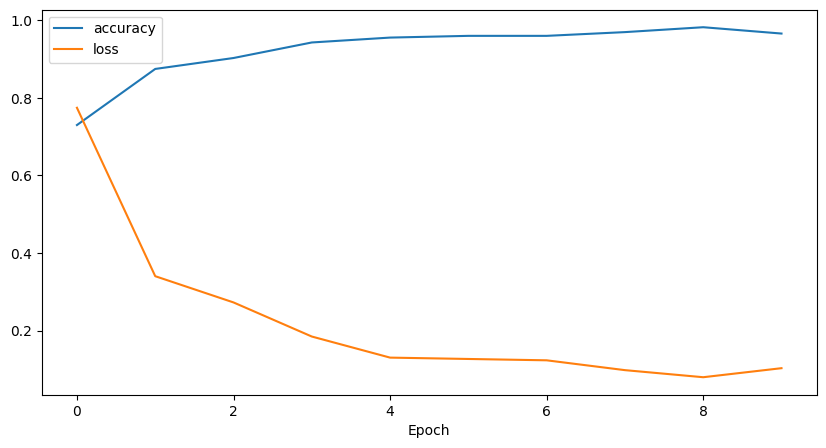

In [29]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [30]:
#Save the model as h5 file
model.save('Model_VGG16.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
